## 初始化

### 调包

In [ ]:
import sys
import os
import time
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm import tqdm
import camb
from camb import model, initialpower
import warnings 
warnings.filterwarnings('ignore')
sys.path.append("/home/chenzy/code/")
import illustris_python as il
import h5py
from scipy.spatial import KDTree
from basical_para import *    #basePath_tng100, particle_dm_mass, boxlen_100(kpc/h)

: 

In [ ]:
conda install -n cosm ipykernel --update-deps --force-reinstall

: 

### 常数定义

In [1]:
basePath_tng100="/home/cossim/IllustrisTNG/TNG100-1/"
particle_dm_mass=0.00050557*10**10   #M_sun/h
boxlen_100=75000    #ckpc/h

### 读数据

In [47]:
#Halos
#Group中第一个subhalo对应的坐标
GroupFirstSub=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupFirstSub")
#Group的坐标 ckpc/h
GroupPos=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupPos")
#Group的速度 km/s/a
GroupVel=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupVel")
#mass 200   10^10 M_sun/h
Group_M_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_M_Mean200")
# R mean 200 ckpc/h
Group_R_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_R_Mean200")


#subhalo
#subhalo的坐标 ckpc/h
SubhaloPos=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloPos")
#subhalo是否可靠
SubhaloFlag=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloFlag")
#subhalo 的速度 km/s
SubhaloVel=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloVel")
# all mass
SubhaloMass=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMass")
# mass type
SubhaloMassType=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMassType")
SubhaloMass_Star=SubhaloMassType[:,4]

#offset file
f = h5py.File("/home/cossim/IllustrisTNG/TNG100-1/postprocessing/offsets/offsets_099.hdf5", "r")
pid_group=f["Group/SnapByType"][:]
pid_subhalo=f["Subhalo/SnapByType"][:]
parttype_id={"gas":0,"dm":1,"star":4}


d=np.load("I_quad.npz")
subgroup_I_dm=d["subgroup_I_dm"]
subgroup_vector_dm=d["subgroup_vector_dm"]
subgroup_value_dm=d["subgroup_value_dm"]

In [4]:
label1=np.where(subgroup_value_dm[:,1]!=0)[0]
label2=np.where(subgroup_value_dm[label1,0]/subgroup_value_dm[label1,1]>5)[0]
print(label2)
subgroup_I_dm[label1[label2],:,:]=0
subgroup_vector_dm[label1[label2],:]=0
subgroup_value_dm[label1[label2]]=0

[   242    269    276 ... 750820 750831 750984]


### 函数定义

In [5]:
#对于一个group获得其subhalo的ID，包含它自己
def get_subhaloID(GroupID):
    if GroupFirstSub[GroupID]==-1:
        return 0
    return np.arange(GroupFirstSub[GroupID],GroupFirstSub[GroupID+1])

#在考虑循环边界条件的情况下计算粒子间的距离
def get_pos_diff(pos_a,pos_b,boxlen):
    diff1=pos_b-pos_a
    diff2=pos_b-pos_a
    diff2[np.where(np.abs(diff1)>boxlen/2)]=diff1[np.where(np.abs(diff1)>boxlen/2)]-np.sign(diff1[np.where(np.abs(diff1)>boxlen/2)])*boxlen
    return diff2

#通过 offset 文件：第group_id中的subgroup_id 对应的粒子坐标
#先读 group 包含的所有粒子 再分配到 subhalo
def get_pid_group_subhalo(subgroup_id, group_id, parttype="dm"):
    return [pid_subhalo[subgroup_id,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]],
            pid_subhalo[subgroup_id+1,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]]]

#画图
def plot_histogram(ax, x, y, bins, c="k", label="", alpha=1):
    mean,edge=np.histogram(x,bins=bins,weights=y)
    N,edge=np.histogram(x,bins=bins)
    ax.plot((edge[1:]+edge[:-1])/2,mean/N,c, label=label, alpha=alpha)
    ax.plot((edge[1:]+edge[:-1])/2,-mean/N,c+":", alpha=alpha)

def plot_hist_a_N(ax, a, bins=100, c="k", xlabel=""):
    ax.hist(a,bins=bins,c=c)
    ax.set_xlabel(xlabel)
    


### 样本选择条件

1. M_* > 10^9
2. SubhaloFlag = 1
3. 至少包含一个 dm 粒子
4. a/b<5

# 参考表

## 有 star 的subgroup的个数 ：337261

In [17]:
np.sum(SubhaloMass_Star>0)

337261

## mass distribution

Text(0, 0.5, 'N')

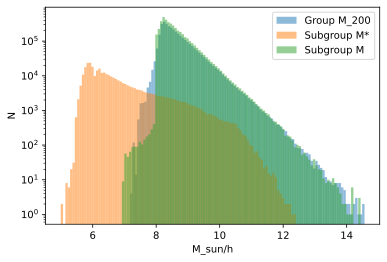

In [48]:
plt.hist(np.log10(Group_M_Mean200[np.where(Group_M_Mean200>0)]*10**10),bins=100, label="Group M_200", alpha=0.5)
plt.hist(np.log10(SubhaloMass_Star[np.where(SubhaloMass_Star>0)]*10**10),bins=100, label="Subgroup M*", alpha=0.5)

plt.hist(np.log10(SubhaloMass[np.where(SubhaloMass>0)]*10**10),bins=100, label="Subgroup M",alpha=0.5)


plt.legend()
plt.yscale("log")
plt.xlabel("M_sun/h")
plt.ylabel("N")

## M_200 - M_*

Text(0, 0.5, 'M_dm')

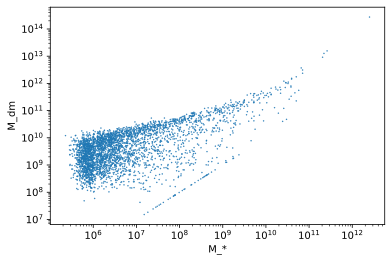

In [34]:
plt.plot(SubhaloMass_Star[np.where(SubhaloMass_Star>0)[0][::100]]*10**10, SubhaloMass[np.where(SubhaloMass_Star>0)[0][::100]]*10**10,".", ms=1)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("M_*")
plt.ylabel("M_dm")



In [27]:
np.where(SubhaloMass_Star>0)[0][::100]
SubhaloMass_Star[np.where(SubhaloMass_Star>0)[0][::100]]
SubhaloMass[np.where(SubhaloMass_Star>0)]

array([2.7477936e+04, 3.6666228e+03, 7.7345551e+02, ..., 1.1180036e-02,
       1.0721726e-02, 1.1700135e-02], dtype=float32)

## dm/gas/star fraction (subgroup)

126 0 750078


Text(0, 0.5, 'f')

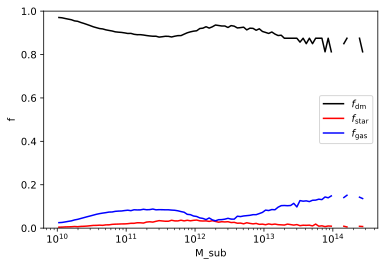

In [123]:

label=np.where((SubhaloMass>10**9/10**10)&(SubhaloFlag!=0))[0]


mass_gas=SubhaloMassType[label,0]
mass_dm=SubhaloMassType[label,1]
mass_star=SubhaloMassType[label,4]
mass_all=mass_gas+mass_star+mass_dm
mass_all=np.sum(SubhaloMassType[label,:], axis=1)
print(np.sum(mass_dm==0), np.sum(SubhaloMass==0), len(label))

fig,ax=plt.subplots()
plot_histogram(ax=ax, x=SubhaloMass[label]*10**10, y=mass_dm/SubhaloMass[label],   bins=10**np.linspace(10,14.5,100), c="k", label=r"$f_{\rm dm}$")
plot_histogram(ax=ax, x=SubhaloMass[label]*10**10, y=mass_star/SubhaloMass[label], bins=10**np.linspace(10,14.5,100), c="r", label=r"$f_{\rm star}$")
plot_histogram(ax=ax, x=SubhaloMass[label]*10**10, y=mass_gas/SubhaloMass[label],  bins=10**np.linspace(10,14.5,100), c="b", label=r"$f_{\rm gas}$")


ax.set_xscale("log")
ax.set_ylim(0,1)
ax.legend()
ax.set_xlabel("M_sub")
ax.set_ylabel("f")

### dm质量=0， 但star/gas质量!=0的 subhalo

126

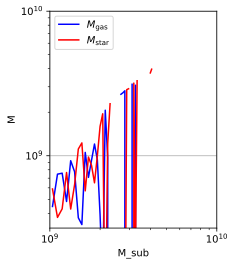

In [125]:
label=np.where(mass_dm==0)[0]
fig,ax=plt.subplots(figsize=(3,4))
plot_histogram(ax=ax, x=mass_all[label]*10**10, y=mass_gas[label]*10**10, bins=100, c="b", label=r"$M_{\rm gas}$")
plot_histogram(ax=ax, x=mass_all[label]*10**10, y=mass_star[label]*10**10, bins=100, c="r", label=r"$M_{\rm star}$")



#plt.hist(mass_gas[label]*10**10,bins=100)
#plt.hist(mass_star[label]*10**10,bins=100)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(10**8.5,10**10)
ax.set_xlim(10**9,10**10)
ax.grid()
ax.legend()
ax.set_xlabel("M_sub")
ax.set_ylabel("M")
len(label)

# save subgroup shape

## 测试要存的数目

In [122]:
label1=np.where((SubhaloMass>10**10/10**10)&(SubhaloFlag!=0))[0]
label2=np.where((SubhaloMass>10**9/10**10)&(SubhaloFlag!=0))[0]
label3=np.where((SubhaloMass_Star>10**9/10**10)&(SubhaloFlag!=0))[0]


print("M_dm>10^10 :", len(label1))
print("M_dm>10^9 :", len(label2))
print("M_*>10^9 :", len(label3))
print(np.min(SubhaloMass[label3]))


M_dm>10^10 : 99603
M_dm>10^9 : 750078
M_*>10^9 : 17611
0.100712955


取所有 SubhaloMass>10^9 的halo

## 3D I quad

In [5]:
subgroup_I_dm=np.zeros((len(SubhaloMass_Star), 3, 3))
subgroup_vector_dm=np.zeros((len(SubhaloMass_Star), 3, 3))
subgroup_value_dm=np.zeros((len(SubhaloMass_Star), 3))
label=np.where(SubhaloMass>10**9/10**10)[0]
partType="dm"

N_dm_0=0
for i in tqdm(label):
    part_pos=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Coordinates")
    if type(part_pos)==dict:
        N_dm_0+=1
        continue

    if partType=="dm":
        particle_mass=np.ones(len(part_pos[:,0]))*particle_dm_mass
    else:
        particle_mass=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Masses")

    pos_diff=get_pos_diff(pos_a=SubhaloPos[i,:],pos_b=part_pos,boxlen=boxlen_100)
    for ii in range(3):
        for jj in range(3):
            subgroup_I_dm[i, ii,jj]=np.sum(particle_mass*pos_diff[:,ii]*pos_diff[:,jj])/np.sum(particle_mass)

    ww, vv =np.linalg.eig(subgroup_I_dm[i,:,:])
    ll=(np.argsort(ww)[::-1])
    subgroup_vector_dm[i,:,:]=vv[:,ll]
    subgroup_value_dm[i,:]=ww[ll]


100%|██████████| 751978/751978 [4:53:25<00:00, 42.71it/s]   


In [6]:
np.savez("I_quad.npz",subgroup_I_dm=subgroup_I_dm, subgroup_vector_dm=subgroup_vector_dm,
        subgroup_value_dm=subgroup_value_dm)

In [5]:
d=np.load("I_quad.npz")
subgroup_I_dm=d["subgroup_I_dm"]
subgroup_vector_dm=d["subgroup_vector_dm"]
subgroup_value_dm=d["subgroup_value_dm"]

# 和文章中的图比较

## q=b/a, s=c/a 的PDF

17822
12789
4123
910


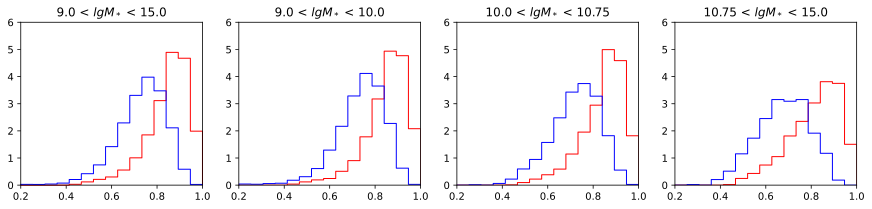

In [20]:
def get_pdf_q_s(subgroup_star_mass_min,subgroup_star_mass_max):
    
    label=np.where((SubhaloMass_Star>=subgroup_star_mass_min/10**10)&(SubhaloMass_Star<=subgroup_star_mass_max/10**10)&(subgroup_value_dm[:,0]!=0))[0]
    print(len(label))
    
    a=np.sqrt(subgroup_value_dm[label,0])
    b=np.sqrt(subgroup_value_dm[label,1])
    c=np.sqrt(subgroup_value_dm[label,2])
    
    return b/a, c/a

fig,ax=plt.subplots(1, 4, figsize=(15,3))
lgM_lim=np.array([[9,15],[9,10],[10,10.75],[10.75,15]])
for i in range(4):
    q, s = get_pdf_q_s(10**(lgM_lim[i,0]), 10**(lgM_lim[i,1]))
    ax[i].hist(q, bins=np.linspace(0.2,1,16), color="r", density=True, histtype="step")
    ax[i].hist(s, bins=np.linspace(0.2,1,16),color="b", density=True, histtype="step")
    ax[i].set_ylim(0,6)
    ax[i].set_xlim(0.2,1)
    ax[i].set_title(str(lgM_lim[i,0])+" < $lgM_*$ < "+str(lgM_lim[i,1]))

## w(r)

17822
12789
4123
910


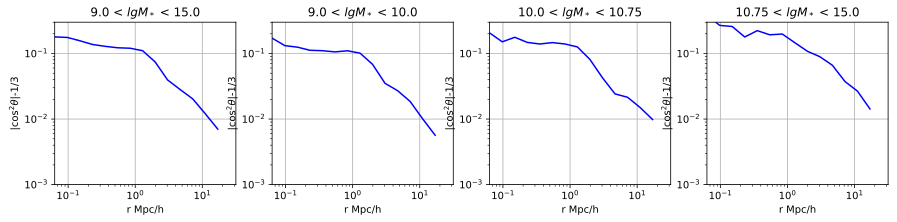

In [21]:
def get_cos_A_r(subgroup_star_mass_min,subgroup_star_mass_max, r_max=10**4):
    #r_bins=10**np.linspace(2,4.3)
    label=np.where((SubhaloMass_Star>=subgroup_star_mass_min/10**10)&(SubhaloMass_Star<=subgroup_star_mass_max/10**10)&(subgroup_value_dm[:,0]!=0))[0]
    print(len(label))
    subgroup_tree=KDTree(SubhaloPos[label,:], boxsize=boxlen_100)
    #N_sub_rbins=subgroup_tree.count_neighbors(subgroup_tree,r=r_bins, cumulative=False)
    pair_index=subgroup_tree.query_pairs(r=r_max, output_type="ndarray")

    r=get_pos_diff(pos_a=SubhaloPos[label[pair_index[:,1]],:],pos_b=SubhaloPos[label[pair_index[:,0]],:],boxlen=boxlen_100) #b-a
    r_len=np.linalg.norm(r, axis=1)

    A1=subgroup_vector_dm[label[pair_index[:,0]],:,0]#;a=w[subgroup_id[j],0];b=w[subgroup_id[j],1]
    A2=subgroup_vector_dm[label[pair_index[:,1]],:,0]

    cos_A_r1=np.sum(A1*r, axis=1)/r_len
    cos_A_r2=np.sum(A2*r, axis=1)/r_len

    return np.hstack([r_len, r_len])/1000, np.hstack([cos_A_r1,cos_A_r2])

fig,ax=plt.subplots(1, 4, figsize=(15,3))
r_bins=10**np.linspace(-1.3,1.5,16)

lgM_lim=np.array([[9,15],[9,10],[10,10.75],[10.75,15]])

for i in range(4):
    r_len, cos_A_r=get_cos_A_r(10**(lgM_lim[i,0]), 10**(lgM_lim[i,1]), r_max=20*10**3)
    plot_histogram(ax=ax[i], x=r_len, y=cos_A_r**2-1/3., bins=r_bins, c="b", label=r"")

    ax[i].set_xscale("log")
    ax[i].set_yscale("log")

    ax[i].set_xlabel("r Mpc/h")
    ax[i].set_ylabel(r"|cos$^2\theta$|-1/3")
    #ax[i].legend(loc=3)
    ax[i].grid()
    ax[i].set_xlim(10**-1.2,10**1.5)
    ax[i].set_ylim(10**-3,0.3)
    ax[i].set_title(str(lgM_lim[i,0])+" < $lgM_*$ < "+str(lgM_lim[i,1]))

# main

## tracer: group & subgroup 以M_dm作为筛选条件

### 中间数据读取

In [3]:
savename='group_sub_Mg11.0_15.0_Ms6.0_15.0_r10000.npy'
(M_200_1h, M_sub_1h, r_len_1h, r_200_1h, v_len_1h, v_para_1h, v_perp_1h, q_1h, cos_A_r_1h, cos_v_r_1h, cos_v_A_1h, M_200_2h, M_sub_2h, r_len_2h, r_200_2h, v_len_2h, v_para_2h, v_perp_2h, cos_A_r_2h, q_2h, cos_v_r_2h, cos_v_A_2h)=np.load(savename, allow_pickle=True)

In [54]:
np.min(Group_M_Mean200[np.where(Group_M_Mean200>0)])

0.0015167228

### repeat fig.10

In [8]:
np.sum(Group_M_Mean200>10**4)

13

In [10]:
v_200_1h=6.56*np.sqrt(M_200_1h/r_200_1h)
v_200_2h=6.56*np.sqrt(M_200_2h/r_200_2h)

In [59]:
len(M_200_1h)

116984

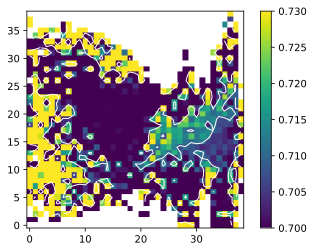

In [37]:
i = 7414

label_1h = np.where(M_200_1h>10**4)[0] #0, 3121, 5571, 7414, 9434
label_2h = np.where(M_200_2h>10**4)[0] #19006
#print(le(label_1h), label_2h)
#label_1h=np.arange(9434)
#label_2h=np.arange(68969)

r_bins=10**np.linspace(-1, 1, 40)
v_bins=np.linspace(-2.5,2.5, 40)
q_mean = np.histogram2d(np.hstack([v_para_1h[label_1h]/v_200_1h[label_1h],v_para_2h[label_2h]/v_200_2h[label_2h]]), 
                        np.hstack([r_len_1h[label_1h]/r_200_1h[label_1h], r_len_2h[label_2h]/r_200_2h[label_2h]]), bins = [v_bins, r_bins],
              weights = np.hstack([q_1h[label_1h], q_2h[label_2h]]))[0]
N = np.histogram2d(np.hstack([v_para_1h[label_1h]/v_200_1h[label_1h],v_para_2h[label_2h]/v_200_2h[label_2h]]), 
                        np.hstack([r_len_1h[label_1h]/r_200_1h[label_1h], r_len_2h[label_2h]/r_200_2h[label_2h]]), bins = [v_bins, r_bins],
              )[0]
#print(N)

#plt.imshow(np.log10(N), origin="lower")

fig, ax =plt.subplots()
plt.imshow(q_mean/N,  origin="lower",vmin=0.7, vmax=0.73)
plt.colorbar()
level=[0.71]
CS2=ax.contour(q_mean/N,level,colors=["w","lightgreen","m","r"],linewidths=1)





In [43]:
i = 0
fig, ax =plt.subplots(figsize=(7,5.5))
#for i in [0, 3121, 5571, 7414]:
#    label_1h = np.where(M_200_1h==M_200_1h[i])[0] #0, 3121, 5571, 7414, 9434
#    label_2h = np.where(M_200_2h==M_200_1h[i])[0] #19006
#    print(label_1h[-1], M_200_1h[i])
label_1h = np.where(M_200_1h>10**4)[0] #0, 3121, 5571, 7414, 9434
label_2h = np.where(M_200_2h>10**4)[0] #19006
ax.plot(r_len_1h[label_1h]/r_200_1h[label_1h], v_para_1h[label_1h]/v_200_1h[label_1h],".k", ms=1, alpha=0.1)#
ax.plot(r_len_2h[label_2h[::10]]/r_200_2h[label_2h[::10]], v_para_2h[label_2h[::10]]/v_200_2h[label_2h[::10]],".k", ms=1, alpha=0.1)
ax.contour((r_bins[1:]+r_bins[:-1])/2, (v_bins[1:]+v_bins[:-1])/2, q_mean/N,levels=level,colors=["r","lightgreen","m","r"],linewidths=2,zorder=100)
#plt.plot([r_200_1h[i], r_200_1h[i]], [-3,3], ":b")
plt.xscale("log")
plt.xlim(0.1,10)
plt.ylim(-2.5,2.5)
plt.xlabel("$r_{200}$ Mpc/h")
plt.ylabel(r"$v_{\parallel}/v_{200}$")
plt.grid()
fig.savefig("1.pdf")
plt.close()

### Subgroup的数目

Text(0.5, 0, 'r/r_200')

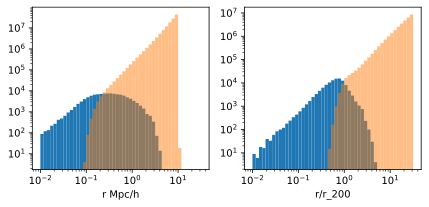

In [7]:
r_bins=10**np.linspace(-2,1.5,50)
fig, ax=plt.subplots(1,2, figsize=(7,3))
ax[0].hist(r_len_1h, bins=r_bins)
ax[0].hist(r_len_2h, bins=r_bins, alpha=0.5)

ax[1].hist(r_len_1h/r_200_1h, bins=r_bins)
ax[1].hist(r_len_2h/r_200_2h, bins=r_bins, alpha=0.5)

for i in [0,1]:
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
ax[0].set_xlabel("r Mpc/h")
ax[1].set_xlabel("r/r_200")

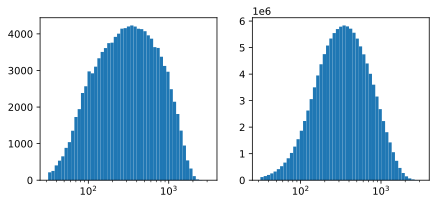

In [8]:
v_bins=10**np.linspace(1.5,3.5,50)

fig, ax=plt.subplots(1,2, figsize=(7,3))
ax[0].hist(v_len_1h, bins=v_bins)
ax[1].hist(v_len_2h, bins=v_bins)
#ax[0].hist(v_len_2h, bins=100, alpha=0.5)

#ax[1].hist(r_len_1h/r_200_1h, bins=r_bins)
#ax[1].hist(r_len_2h/r_200_2h, bins=r_bins, alpha=0.5)

for i in [0,1]:
    ax[i].set_xscale("log")
#    ax[i].set_yscale("log")
#ax[0].set_xlabel("r Mpc/h")
#ax[1].set_xlabel("r/r_200")

### x: r/r_200  y: cos<v.r>

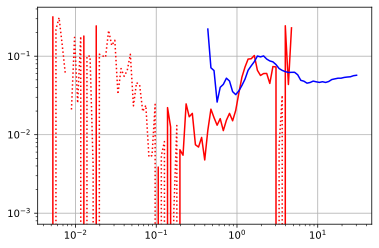

In [23]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-2.3,1.5,100)
label1=np.where((M_200_1h>10**11/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**11/10**10)&(M_200_2h<10**15/10**10))
plot_histogram(ax=ax, x=r_len_1h[label1]/r_200_1h[label1], y=cos_v_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=1)
plot_histogram(ax=ax, x=r_len_2h[label2]/r_200_2h[label2], y=cos_v_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"In group", alpha=1)

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
    

### v-r

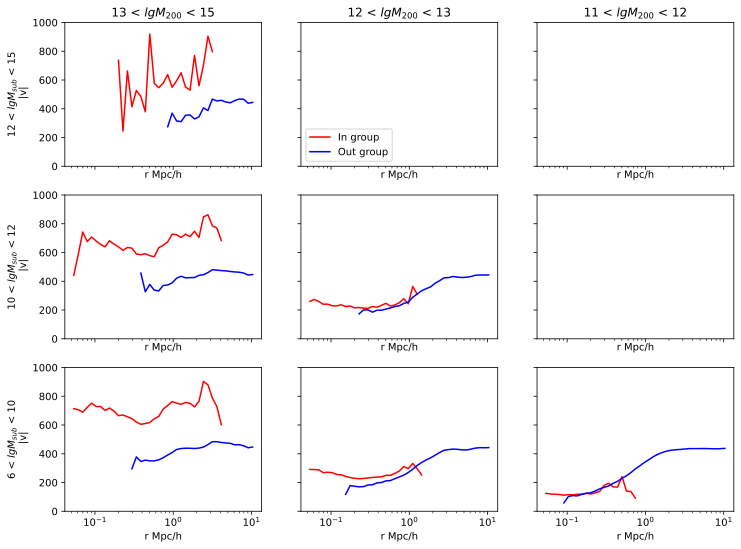

In [9]:
fig, ax=plt.subplots(3,3, figsize=(4*3,3*3), sharex=True, sharey=True)
lgM_200_lim=np.array([[13,15],[12,13],[11,12]])
lgM_sub_lim=np.array([[12,15],[10,12],[6,10]])
r_bins=10**np.linspace(-1.3,1.5,50)

for i in [0, 1, 2]:  #M_sub
    for j in [0,1,2]: #M_200
        
        label1=np.where((M_200_1h>10**lgM_200_lim[j,0]/10**10)&(M_200_1h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_1h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_1h<10**lgM_sub_lim[j,1]/10**10))
        label2=np.where((M_200_2h>10**lgM_200_lim[j,0]/10**10)&(M_200_2h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_2h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_2h<10**lgM_sub_lim[j,1]/10**10))
    
        
        plot_histogram(ax=ax[i,j], x=r_len_1h[label1], y=v_len_1h[label1], bins=r_bins, c="r", label=r"In group", alpha=1)
        plot_histogram(ax=ax[i,j], x=r_len_2h[label2], y=v_len_2h[label2], bins=r_bins, c="b", label=r"Out group", alpha=1)


        
        ax[i,j].set_xscale("log")
        ax[i,j].set_xlabel("r Mpc/h")
        ax[i,j].set_ylim(0,1000)
        
        ax[0,j].set_title(str(lgM_200_lim[j,0])+" < $lgM_{200}$ < "+str(lgM_200_lim[j,1]))
        ax[i,0].set_ylabel(str(lgM_sub_lim[i,0])+" < $lgM_{sub}$ < "+str(lgM_sub_lim[i,1])+"\n |v|")
ax[0,1].legend(loc=3)

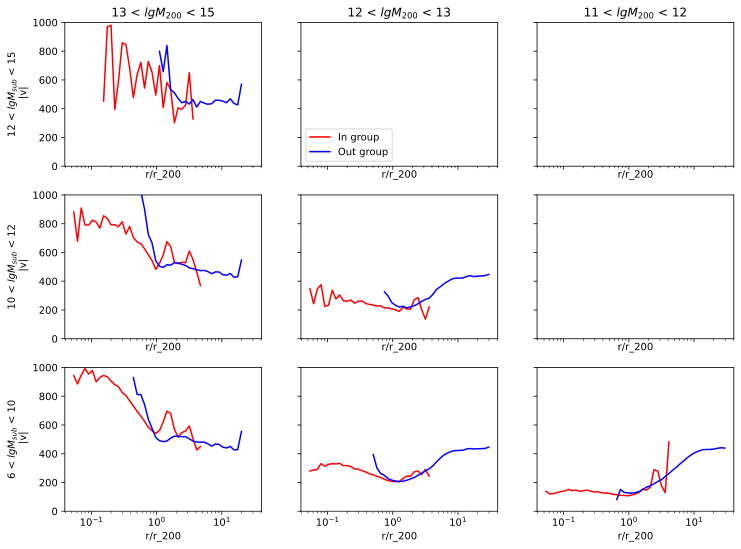

In [10]:
fig, ax=plt.subplots(3,3, figsize=(4*3,3*3), sharex=True, sharey=True)
lgM_200_lim=np.array([[13,15],[12,13],[11,12]])
lgM_sub_lim=np.array([[12,15],[10,12],[6,10]])
r_bins=10**np.linspace(-1.3,1.5,50)

for i in [0, 1, 2]:  #M_sub
    for j in [0,1,2]: #M_200
        
        label1=np.where((M_200_1h>10**lgM_200_lim[j,0]/10**10)&(M_200_1h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_1h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_1h<10**lgM_sub_lim[j,1]/10**10))
        label2=np.where((M_200_2h>10**lgM_200_lim[j,0]/10**10)&(M_200_2h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_2h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_2h<10**lgM_sub_lim[j,1]/10**10))
    
        
        plot_histogram(ax=ax[i,j], x=r_len_1h[label1]/r_200_1h[label1], y=v_len_1h[label1], bins=r_bins, c="r", label=r"In group", alpha=1)
        plot_histogram(ax=ax[i,j], x=r_len_2h[label2]/r_200_2h[label2], y=v_len_2h[label2], bins=r_bins, c="b", label=r"Out group", alpha=1)


        
        ax[i,j].set_xscale("log")
        ax[i,j].set_xlabel("r/r_200")
        ax[i,j].set_ylim(0,1000)
        
        ax[0,j].set_title(str(lgM_200_lim[j,0])+" < $lgM_{200}$ < "+str(lgM_200_lim[j,1]))
        ax[i,0].set_ylabel(str(lgM_sub_lim[i,0])+" < $lgM_{sub}$ < "+str(lgM_sub_lim[i,1])+"\n |v|")
ax[0,1].legend(loc=3)

#### Cos<A.r>, cos<v.r>, cos<v.A> as a function of r （按M_200分bin）

横坐标：r Mpc/h

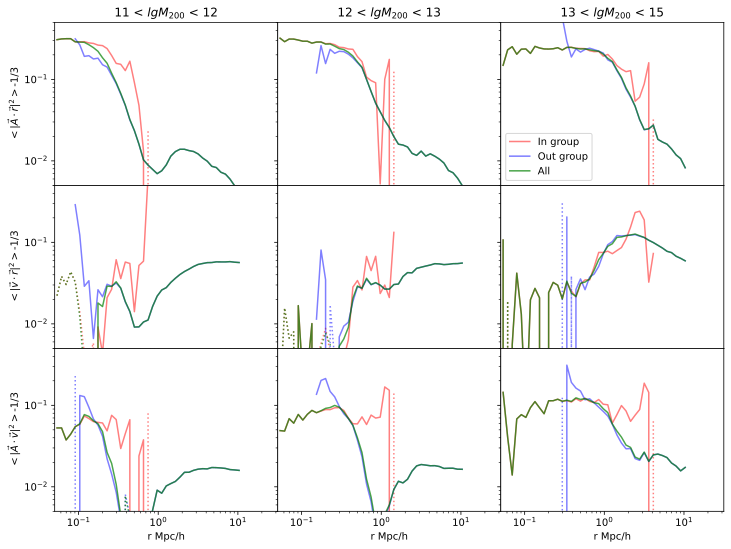

In [10]:
r_bins=10**np.linspace(-1.3,1.5,50)
fig,ax=plt.subplots(3,3,figsize=(4*3,3*3), sharex=True, sharey=True, gridspec_kw={"hspace":0,"wspace":0,})

lgM_lim=np.array([[11,12],[12,13],[13,15]])

for i in [0,1,2]:
    label1=np.where((M_200_1h>10**lgM_lim[i,0]/10**10)&(M_200_1h<10**lgM_lim[i,1]/10**10))
    label2=np.where((M_200_2h>10**lgM_lim[i,0]/10**10)&(M_200_2h<10**lgM_lim[i,1]/10**10))
    
    
    plot_histogram(ax=ax[0,i], x=r_len_1h[label1], y=cos_A_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=r_len_2h[label2], y=cos_A_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_A_r_1h[label1],cos_A_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    
    plot_histogram(ax=ax[1,i], x=r_len_1h[label1], y=cos_v_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=r_len_2h[label2], y=cos_v_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_v_r_1h[label1],cos_v_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    

    plot_histogram(ax=ax[2,i], x=r_len_1h[label1], y=cos_v_A_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=r_len_2h[label2], y=cos_v_A_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_v_A_1h[label1],cos_v_A_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    for j in [0,1,2]:
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlim(r_bins[0], r_bins[-1])
        ax[j,i].set_ylim(0.005,0.5)
        ax[2,i].set_xlabel("r Mpc/h")
        
        ax[0,i].set_title(str(lgM_lim[i,0])+" < $lgM_{200}$ < "+str(lgM_lim[i,1]))
    ax[0,0].set_ylabel(r"$<|\vec A \cdot \vec r|^2>$-1/3")
    ax[1,0].set_ylabel(r"$<|\vec v \cdot \vec r|^2>$-1/3")
    ax[2,0].set_ylabel(r"$<|\vec A \cdot \vec v|^2>$-1/3")


ax[0,2].legend(loc=3)

横坐标：r/r_200

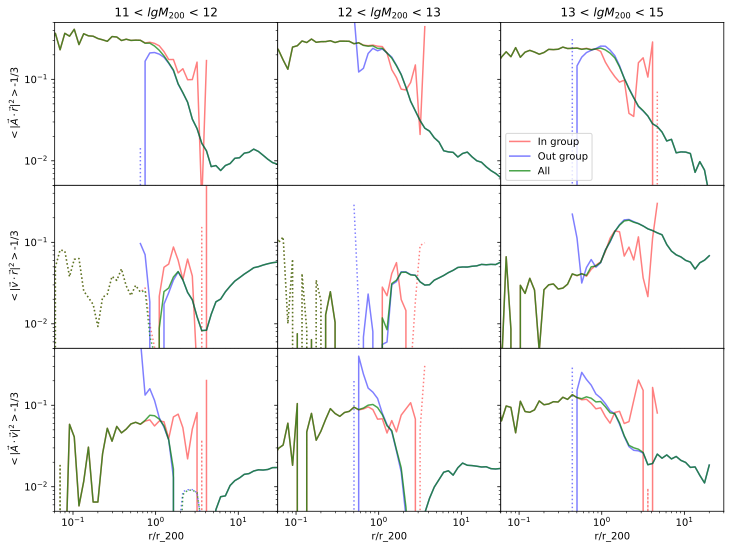

In [11]:
r_bins=10**np.linspace(-1.3,1.5,50)
fig,ax=plt.subplots(3,3,figsize=(4*3,3*3), sharex=True, sharey=True,gridspec_kw={"hspace":0,"wspace":0,})

lgM_lim=np.array([[11,12],[12,13],[13,15]])

for i in [0,1,2]:
    label1=np.where((M_200_1h>10**lgM_lim[i,0]/10**10)&(M_200_1h<10**lgM_lim[i,1]/10**10))
    label2=np.where((M_200_2h>10**lgM_lim[i,0]/10**10)&(M_200_2h<10**lgM_lim[i,1]/10**10))
    
    
    plot_histogram(ax=ax[0,i], x=r_len_1h[label1]/r_200_1h[label1], y=cos_A_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=r_len_2h[label2]/r_200_2h[label2], y=cos_A_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]), y=np.hstack([cos_A_r_1h[label1],cos_A_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    
    plot_histogram(ax=ax[1,i], x=r_len_1h[label1]/r_200_1h[label1], y=cos_v_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=r_len_2h[label2]/r_200_2h[label2], y=cos_v_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]), y=np.hstack([cos_v_r_1h[label1],cos_v_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    

    plot_histogram(ax=ax[2,i], x=r_len_1h[label1]/r_200_1h[label1], y=cos_v_A_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=r_len_2h[label2]/r_200_2h[label2], y=cos_v_A_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]), y=np.hstack([cos_v_A_1h[label1],cos_v_A_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    for j in [0,1,2]:
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlim(0.06, 30)
        ax[j,i].set_ylim(0.005,0.5)
        ax[2,i].set_xlabel("r/r_200")
        
        ax[0,i].set_title(str(lgM_lim[i,0])+" < $lgM_{200}$ < "+str(lgM_lim[i,1]))
    ax[0,0].set_ylabel(r"$<|\vec A \cdot \vec r|^2>$-1/3")
    ax[1,0].set_ylabel(r"$<|\vec v \cdot \vec r|^2>$-1/3")
    ax[2,0].set_ylabel(r"$<|\vec A \cdot \vec v|^2>$-1/3")


ax[0,2].legend(loc=3)

#### q as a function of r

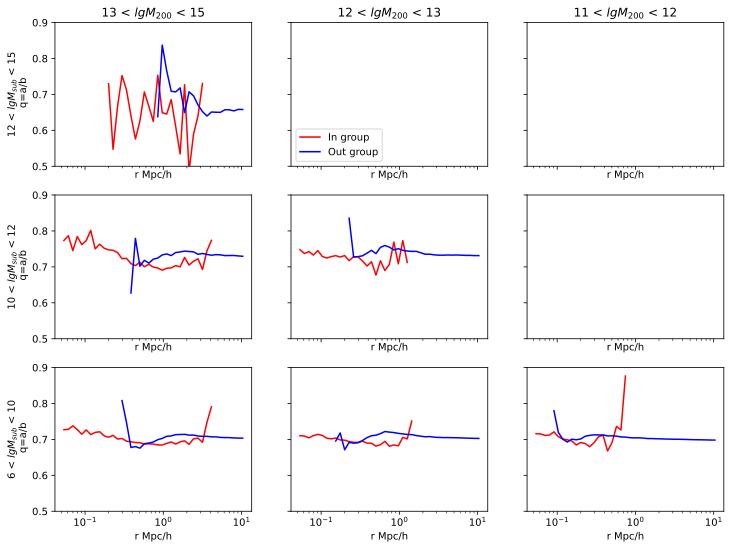

In [12]:
fig, ax=plt.subplots(3,3, figsize=(4*3,3*3), sharex=True, sharey=True)
lgM_200_lim=np.array([[13,15],[12,13],[11,12]])
lgM_sub_lim=np.array([[12,15],[10,12],[6,10]])
r_bins=10**np.linspace(-1.3,1.5,50)

for i in [0, 1, 2]:  #M_sub
    for j in [0,1,2]: #M_200
        
        label1=np.where((M_200_1h>10**lgM_200_lim[j,0]/10**10)&(M_200_1h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_1h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_1h<10**lgM_sub_lim[j,1]/10**10))
        label2=np.where((M_200_2h>10**lgM_200_lim[j,0]/10**10)&(M_200_2h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_2h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_2h<10**lgM_sub_lim[j,1]/10**10))
            
        plot_histogram(ax=ax[i,j], x=r_len_1h[label1], y=q_1h[label1], bins=r_bins, c="r", label=r"In group", alpha=1)
        plot_histogram(ax=ax[i,j], x=r_len_2h[label2], y=q_2h[label2], bins=r_bins, c="b", label=r"Out group", alpha=1)

        ax[i,j].set_xscale("log")
        ax[i,j].set_xlabel("r Mpc/h")
        ax[i,j].set_ylim(0.5,0.9)
        
        ax[0,j].set_title(str(lgM_200_lim[j,0])+" < $lgM_{200}$ < "+str(lgM_200_lim[j,1]))
        ax[i,0].set_ylabel(str(lgM_sub_lim[i,0])+" < $lgM_{sub}$ < "+str(lgM_sub_lim[i,1])+"\n q=a/b")
ax[0,1].legend(loc=3)

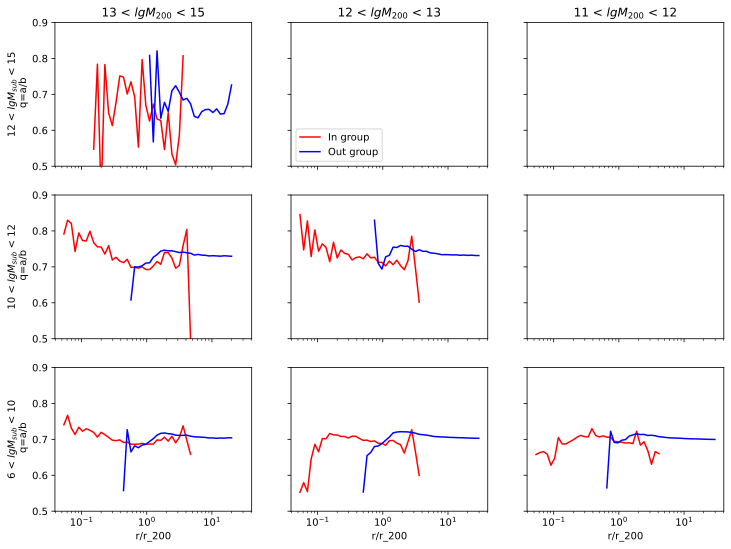

In [13]:
fig, ax=plt.subplots(3,3, figsize=(4*3,3*3), sharex=True, sharey=True)
lgM_200_lim=np.array([[13,15],[12,13],[11,12]])
lgM_sub_lim=np.array([[12,15],[10,12],[6,10]])
r_bins=10**np.linspace(-1.3,1.5,50)

for i in [0, 1, 2]:  #M_sub
    for j in [0,1,2]: #M_200
        
        label1=np.where((M_200_1h>10**lgM_200_lim[j,0]/10**10)&(M_200_1h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_1h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_1h<10**lgM_sub_lim[j,1]/10**10))
        label2=np.where((M_200_2h>10**lgM_200_lim[j,0]/10**10)&(M_200_2h<10**lgM_200_lim[j,1]/10**10)&
                       (M_sub_2h>10**lgM_sub_lim[i,0]/10**10)&(M_sub_2h<10**lgM_sub_lim[j,1]/10**10))
    
        
        plot_histogram(ax=ax[i,j], x=r_len_1h[label1]/r_200_1h[label1], y=q_1h[label1], bins=r_bins, c="r", label=r"In group", alpha=1)
        plot_histogram(ax=ax[i,j], x=r_len_2h[label2]/r_200_2h[label2], y=q_2h[label2], bins=r_bins, c="b", label=r"Out group", alpha=1)


        
        ax[i,j].set_xscale("log")
        ax[2,j].set_xlabel("r/r_200")
        ax[i,j].set_ylim(0.5,0.9)
        
        ax[0,j].set_title(str(lgM_200_lim[j,0])+" < $lgM_{200}$ < "+str(lgM_200_lim[j,1]))
        ax[i,0].set_ylabel(str(lgM_sub_lim[i,0])+" < $lgM_{sub}$ < "+str(lgM_sub_lim[i,1])+"\n q=a/b")
ax[0,1].legend(loc=3)

#### q as a function of v （r/r_200 分bin）

/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda-mamba/envs/mamba-python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: Runtime

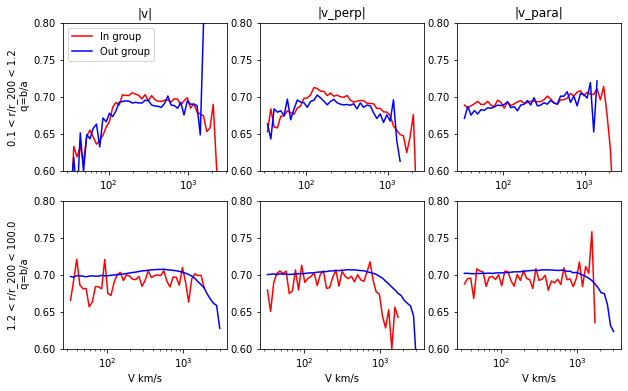

In [25]:
fig, ax=plt.subplots(2,3, figsize=(10,3*2))
v_bins=10**np.linspace(1.5,3.5,50)

r_lim=np.array([[0.1,1.2],[1.2, 100]])

for i in [0,1]:
    label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10)&(r_len_1h/r_200_1h>r_lim[i,0])&(r_len_1h/r_200_1h<r_lim[i,1]))
    label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10)&(r_len_2h/r_200_2h>r_lim[i,0])&(r_len_2h/r_200_2h<r_lim[i,1]))


    plot_histogram(ax=ax[i,0], x=v_len_1h[label1], y=q_1h[label1], bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,0], x=v_len_2h[label2], y=q_2h[label2], bins=v_bins, c="b", label=r"Out group", alpha=1)

    plot_histogram(ax=ax[i,1], x=v_perp_1h[label1], y=q_1h[label1], bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,1], x=v_perp_2h[label2], y=q_2h[label2], bins=v_bins, c="b", label=r"Out group", alpha=1)

    plot_histogram(ax=ax[i,2], x=np.abs(v_para_1h[label1]), y=q_1h[label1], bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,2], x=np.abs(v_para_2h[label2]), y=q_2h[label2], bins=v_bins, c="b", label=r"Out group", alpha=1)

    for j in [0,1,2]:
        ax[i,j].set_xscale("log")
        ax[i,j].set_ylim(0.6,.8)
        ax[1,j].set_xlabel("V km/s")
        ax[i,0].set_ylabel(str(r_lim[i,0])+" < r/r_200 < "+str(r_lim[i,1])+"\n q=b/a")
    
ax[0,0].set_title("|v|")
ax[0,1].set_title("|v_perp|")
ax[0,2].set_title("|v_para|")
ax[0,0].legend(loc=2)


#### cos<A.v> as a function of v

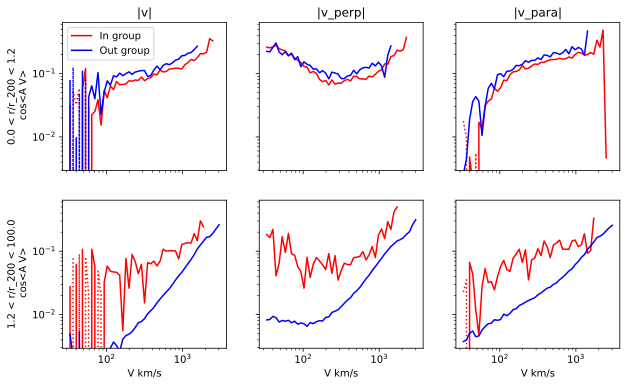

In [6]:
fig, ax=plt.subplots(2,3, figsize=(10,3*2), sharey=True, sharex=True)
v_bins=10**np.linspace(1.5,3.5,50)

r_lim=np.array([[0,1.2],[1.2, 100]])

for i in [0,1]:
    label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10)&(r_len_1h/r_200_1h>r_lim[i,0])&(r_len_1h/r_200_1h<r_lim[i,1]))
    label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10)&(r_len_2h/r_200_2h>r_lim[i,0])&(r_len_2h/r_200_2h<r_lim[i,1]))


    plot_histogram(ax=ax[i,0], x=v_len_1h[label1], y=cos_v_A_1h[label1]**2-1/3., bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,0], x=v_len_2h[label2], y=cos_v_A_2h[label2]**2-1/3., bins=v_bins, c="b", label=r"Out group", alpha=1)

    plot_histogram(ax=ax[i,1], x=v_perp_1h[label1], y=cos_v_A_1h[label1]**2-1/3., bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,1], x=v_perp_2h[label2], y=cos_v_A_2h[label2]**2-1/3., bins=v_bins, c="b", label=r"Out group", alpha=1)

    plot_histogram(ax=ax[i,2], x=np.abs(v_para_1h[label1]), y=cos_v_A_1h[label1]**2-1/3., bins=v_bins, c="r", label=r"In group", alpha=1)
    plot_histogram(ax=ax[i,2], x=np.abs(v_para_2h[label2]), y=cos_v_A_2h[label2]**2-1/3., bins=v_bins, c="b", label=r"Out group", alpha=1)

    for j in [0,1,2]:
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        #ax[i,j].set_ylim(0.6,.8)
        ax[1,j].set_xlabel("V km/s")
        ax[i,0].set_ylabel(str(r_lim[i,0])+" < r/r_200 < "+str(r_lim[i,1])+"\n cos<A V>")
    
ax[0,0].set_title("|v|")
ax[0,1].set_title("|v_perp|")
ax[0,2].set_title("|v_para|")
ax[0,0].legend(loc=2)

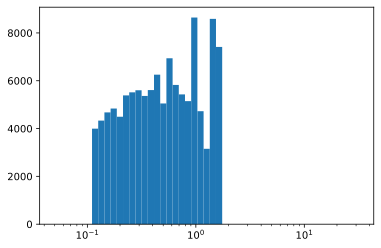

In [26]:
label1=np.where((M_200_1h>10**11/10**10)&(M_200_1h<10**15/10**10))
plt.hist(r_200_1h[label1],bins=r_bins)

plt.xscale("log")

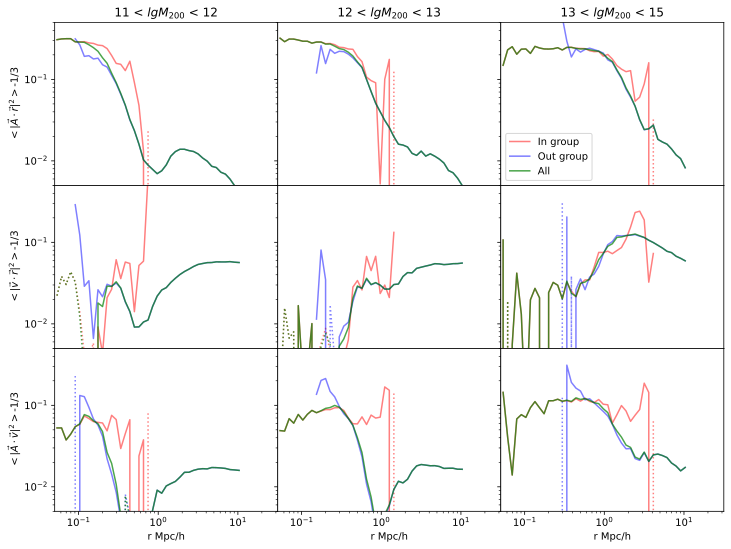

In [24]:
r_bins=10**np.linspace(-1.3,1.5,50)
fig,ax=plt.subplots(3,3,figsize=(4*3,3*3), sharex=True, sharey=True, gridspec_kw={"hspace":0,"wspace":0,})

lgM_lim=np.array([[11,12],[12,13],[13,15]])

for i in [0,1,2]:
    label1=np.where((M_200_1h>10**lgM_lim[i,0]/10**10)&(M_200_1h<10**lgM_lim[i,1]/10**10))
    label2=np.where((M_200_2h>10**lgM_lim[i,0]/10**10)&(M_200_2h<10**lgM_lim[i,1]/10**10))
    
    
    plot_histogram(ax=ax[0,i], x=r_len_1h[label1], y=cos_A_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=r_len_2h[label2], y=cos_A_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[0,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_A_r_1h[label1],cos_A_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    
    plot_histogram(ax=ax[1,i], x=r_len_1h[label1], y=cos_v_r_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=r_len_2h[label2], y=cos_v_r_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[1,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_v_r_1h[label1],cos_v_r_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    

    plot_histogram(ax=ax[2,i], x=r_len_1h[label1], y=cos_v_A_1h[label1]**2-1/3., bins=r_bins, c="r", label=r"In group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=r_len_2h[label2], y=cos_v_A_2h[label2]**2-1/3., bins=r_bins, c="b", label=r"Out group", alpha=0.5)
    plot_histogram(ax=ax[2,i], x=np.hstack([r_len_1h[label1],r_len_2h[label2]]), y=np.hstack([cos_v_A_1h[label1],cos_v_A_2h[label2]])**2-1/3., bins=r_bins, c="g", label=r"All", alpha=0.7)
    
    for j in [0,1,2]:
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlim(r_bins[0], r_bins[-1])
        ax[j,i].set_ylim(0.005,0.5)
        ax[2,i].set_xlabel("r Mpc/h")
        
        ax[0,i].set_title(str(lgM_lim[i,0])+" < $lgM_{200}$ < "+str(lgM_lim[i,1]))
    ax[0,0].set_ylabel(r"$<|\vec A \cdot \vec r|^2>$-1/3")
    ax[1,0].set_ylabel(r"$<|\vec v \cdot \vec r|^2>$-1/3")
    ax[2,0].set_ylabel(r"$<|\vec A \cdot \vec v|^2>$-1/3")


ax[0,2].legend(loc=3)

In [ ]:
1

### V-r 2d-hist

In [14]:
def turn_label_tick(label_ticks, imshow_ticks):
#label_ticks, 在哪些地方放标签
#imshow_ticks, 0，1，2.。。。对应的值
    y=interpolate.interp1d(imshow_ticks, np.arange(len(imshow_ticks))-0.5)
    label_str=["%.1f" % number for number in label_ticks]
    
    return y(label_ticks), label_str

def plot_v_r_2d_hist_q(ax, r_bins, v_bins, r, v, q, vmax=0.8, vmin=0.6, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    q_mean,v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], weights=q)
    q_mean=q_mean/N
    
    image=ax.imshow(q_mean, origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('q=b/a') 

    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2

def plot_v_r_2d_hist_N(ax, r_bins, v_bins, r, v, vmax=3, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    
    image = ax.imshow(np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2)), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('np.log10(N)')
    
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=(r_edge[1:]+r_edge[:-1])/2)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=(v_edge[1:]+v_edge[:-1])/2)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2

def plot_v_r_2d_hist_N(ax, r_bins, v_bins, r, v, vmax=3, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    
    
    image = ax.imshow(np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2)), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('np.log10(N)')
    
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=(r_edge[1:]+r_edge[:-1])/2)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=(v_edge[1:]+v_edge[:-1])/2)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2




Text(0.5, 1.0, 'V_para')

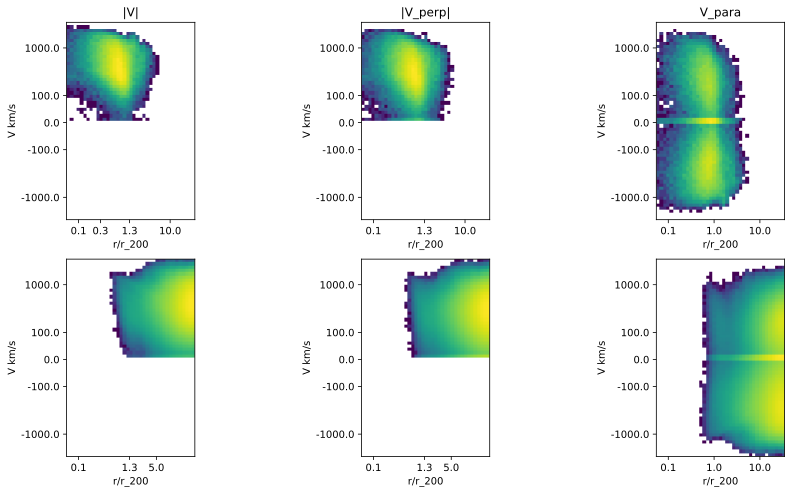

In [9]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_N(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_N(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_N(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_N(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_N(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_N(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


Text(0.5, 1.0, 'V_para')

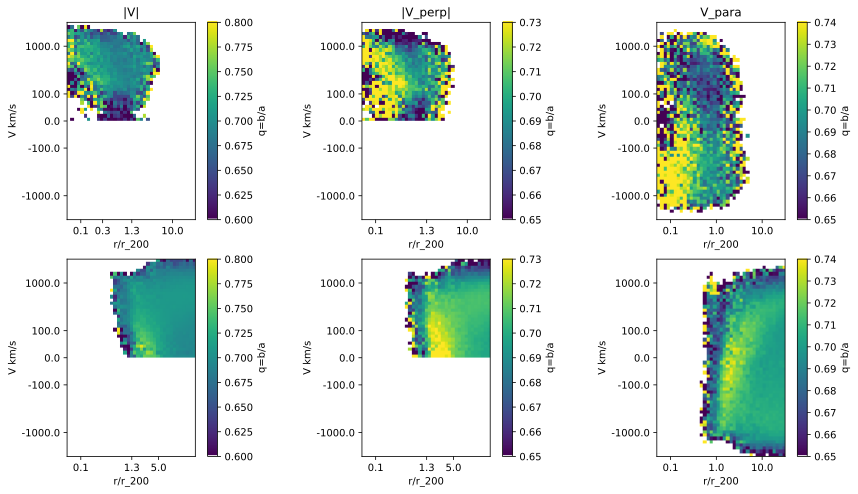

In [5]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


#### subhalo number

Text(0.5, 1.0, 'V_para')

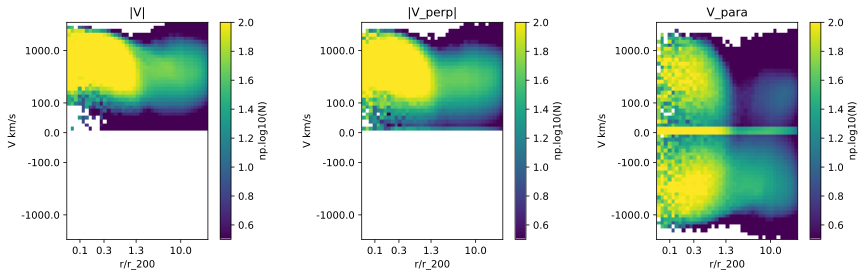

In [16]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])
#v_bins=np.linspace(-3000,3000,50)

label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(1,3, figsize=(5*3, 4))
plot_v_r_2d_hist_N(ax[0], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_len_1h[label1], v_len_2h[label2]]), vmax=2, vmin=0.5, r_ticks=[0.1,0.3,1.3,10])

plot_v_r_2d_hist_N(ax[1], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_perp_1h[label1], v_perp_2h[label2]]), vmax=2, vmin=0.5, r_ticks=[0.1,0.3,1.3,10])

plot_v_r_2d_hist_N(ax[2], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1],r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_para_1h[label1], v_para_2h[label2]]), vmax=2, vmin=0.5, r_ticks=[0.1,0.3,1.3,10])

ax[0].set_title("|V|")
ax[1].set_title("|V_perp|")
ax[2].set_title("V_para")


Text(0.5, 1.0, 'V_para')

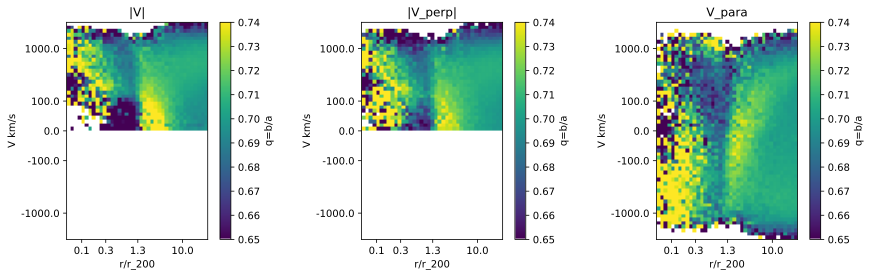

In [9]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])
#v_bins=np.linspace(-3000,3000,50)

label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(1,3, figsize=(5*3, 4))
plot_v_r_2d_hist_q(ax[0], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1], r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_len_1h[label1], v_len_2h[label2]]), q=np.hstack([q_1h[label1],q_2h[label2]]) , vmax=0.74, vmin=0.65, r_ticks=[0.1,0.3,1.3,10])

plot_v_r_2d_hist_q(ax[1], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1], r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_perp_1h[label1], v_perp_2h[label2]]), q=np.hstack([q_1h[label1],q_2h[label2]]) , vmax=0.74, vmin=0.65, r_ticks=[0.1,0.3,1.3,10])

plot_v_r_2d_hist_q(ax[2], r_bins, v_bins, r=np.hstack([r_len_1h[label1]/r_200_1h[label1], r_len_2h[label2]/r_200_2h[label2]]),
                   v=np.hstack([v_para_1h[label1], v_para_2h[label2]]), q=np.hstack([q_1h[label1],q_2h[label2]]) , vmax=0.74, vmin=0.65, r_ticks=[0.1,0.3,1.3,10])

ax[0].set_title("|V|")
ax[1].set_title("|V_perp|")
ax[2].set_title("V_para")


#### 检查M_200是否影响结果

11< lgM_200 < 12

Text(0.5, 1.0, 'V_para')

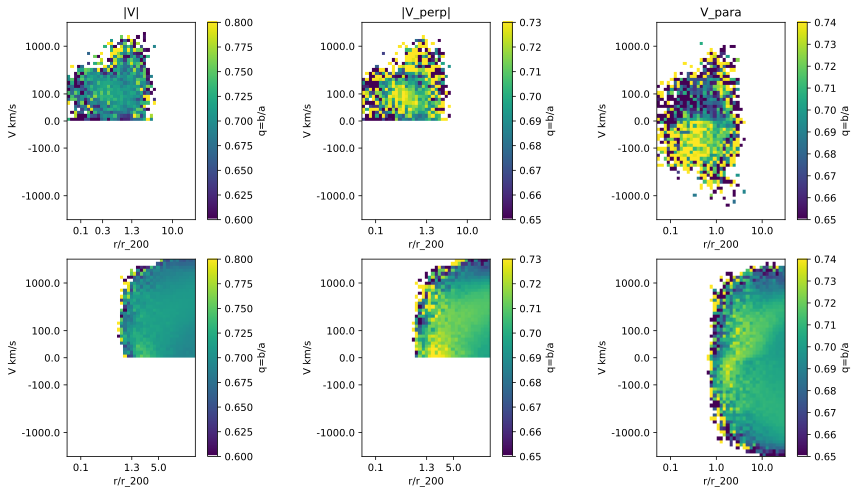

In [38]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**11/10**10)&(M_200_1h<10**12/10**10))
label2=np.where((M_200_2h>10**11/10**10)&(M_200_2h<10**12/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


12< lgM_200 < 13

Text(0.5, 1.0, 'V_para')

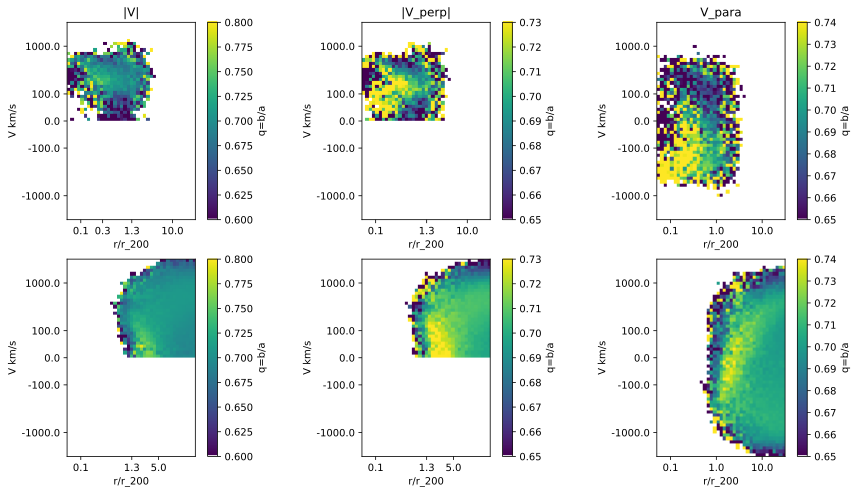

In [39]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**13/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**13/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


13< lgM_200 < 15

Text(0.5, 1.0, 'V_para')

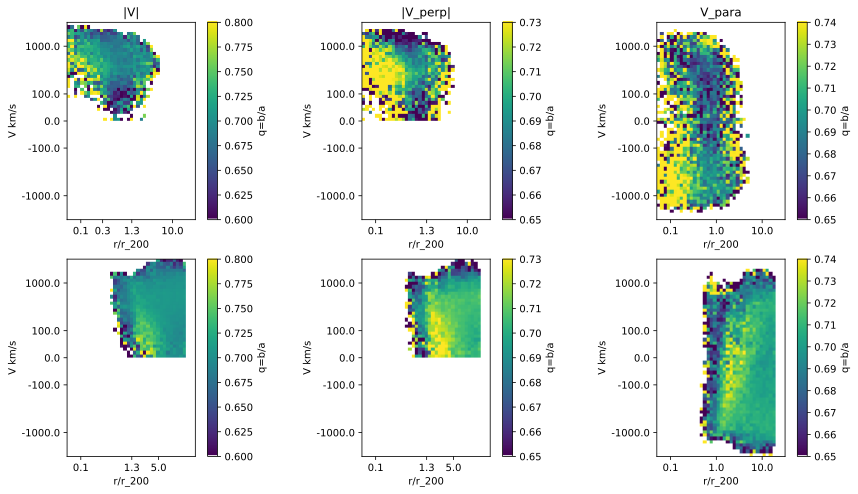

In [40]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**13/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**13/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


#### 检查M_sub是否影响结果

In [46]:
np.min(M_sub_2h)

0.10000145435333252

Text(0.5, 1.0, 'V_para')

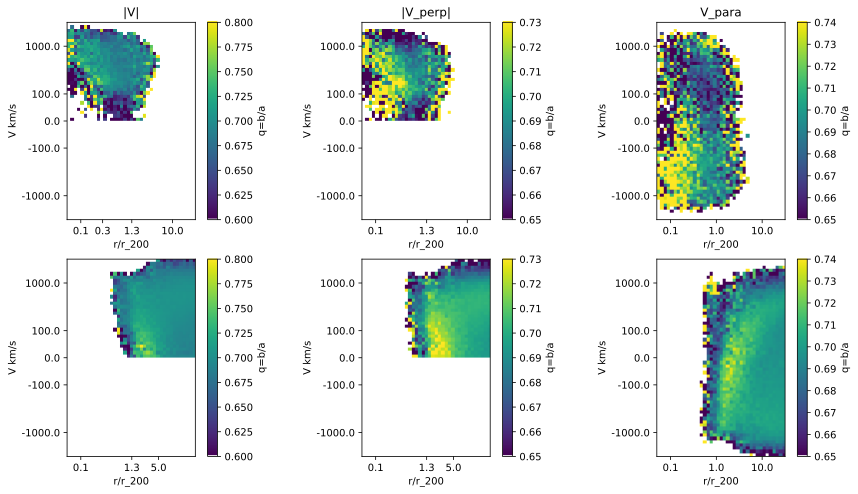

In [59]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10)&(M_sub_1h<10**10/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10)&(M_sub_2h<10**10/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


Text(0.5, 1.0, 'V_para')

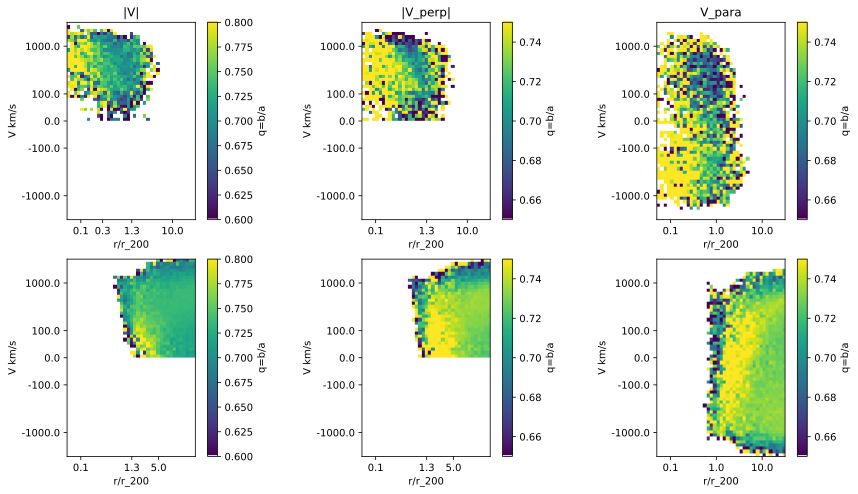

In [61]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10)&(M_sub_1h>10**10/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10)&(M_sub_2h>10**10/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.75, vmin=0.65, r_ticks=[0.1,1.3,10])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.75, vmin=0.65, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.75, vmin=0.65)
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.75, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


#### norm v_200

In [14]:
v_200_1h=6.56*np.sqrt(M_200_1h/r_200_1h)
v_200_2h=6.56*np.sqrt(M_200_2h/r_200_2h)

In [13]:
r_200_1h

array([1.70319153, 1.70319153, 1.70319153, ..., 0.11435983, 0.1134312 ,
       0.11172557])

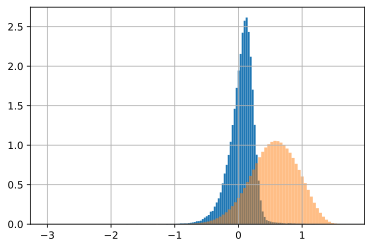

In [16]:
plt.hist(np.log10(v_len_1h/v_200_1h), bins=100, density=True)
plt.hist(np.log10(v_len_2h/v_200_2h), bins=100, density=True, alpha=0.5)
plt.grid()


Text(0.5, 1.0, 'V_para')

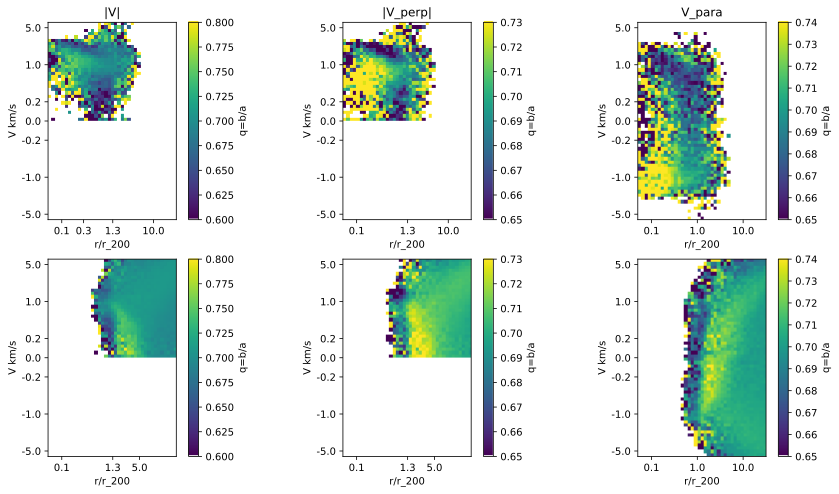

In [21]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(-1,0.8,30)[::-1],[0],10**np.linspace(-1,0.8,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_q(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1]/v_200_1h[label1], q=q_1h[label1], vmax=0.8, vmin=0.6, r_ticks=[0.1,0.3,1.3,10], v_ticks=[-5,-1,-0.2,0,0.2,1,5])
plot_v_r_2d_hist_q(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2]/v_200_2h[label2], q=q_2h[label2], vmax=0.8, vmin=0.6, r_ticks=[0.1,1.3, 5], v_ticks=[-5,-1,-0.2,0,0.2,1,5])

plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1]/v_200_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10], v_ticks=[-5,-1,-0.2,0,0.2,1,5])
plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2]/v_200_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5], v_ticks=[-5,-1,-0.2,0,0.2,1,5])

plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1]/v_200_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65, v_ticks=[-5,-1,-0.2,0,0.2,1,5])
plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2]/v_200_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65, v_ticks=[-5,-1,-0.2,0,0.2,1,5])

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


### V-r 2h-hist cos

In [8]:
def plot_v_r_2d_hist_cos(ax, r_bins, v_bins, r, v, cos, vmax=0.8, vmin=0.6, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], )
    cos_mean,v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], weights=cos**2-1/3.)
    cos_mean=cos_mean/N
    
    image=ax.imshow((cos_mean), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('|cos^2|-1/3') 

    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)

#### cos A_r

Text(0.5, 1.0, 'V_para')

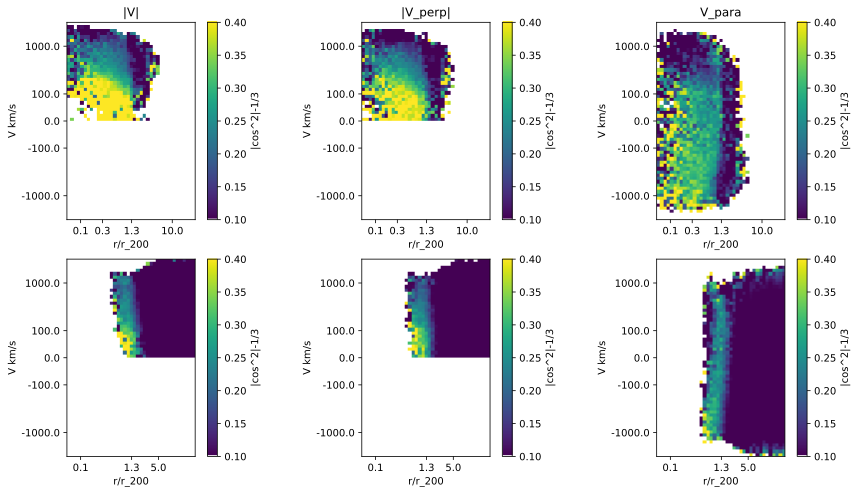

In [9]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_cos(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], cos=cos_A_r_1h[label1], vmax=0.4, vmin=0.1, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], cos=cos_A_r_2h[label2], vmax=0.4, vmin=0.1, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], cos=cos_A_r_1h[label1], vmax=0.4, vmin=0.1, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], cos=cos_A_r_2h[label2], vmax=0.4, vmin=0.1, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], cos=cos_A_r_1h[label1], vmax=0.4, vmin=0.1, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], cos=cos_A_r_2h[label2], vmax=0.4, vmin=0.1, r_ticks=[0.1,1.3, 5])



#plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
#plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

#plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
#plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


#### cos v_A

Text(0.5, 1.0, 'V_para')

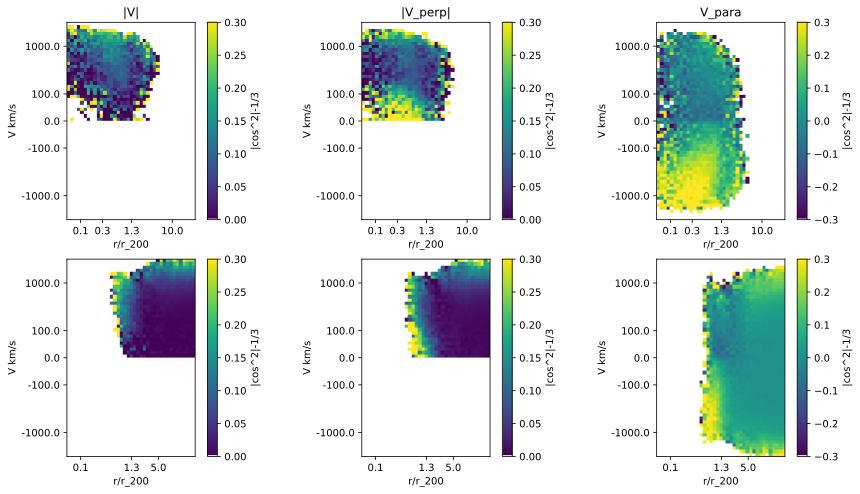

In [10]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_cos(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], cos=cos_v_A_1h[label1], vmax=0.3, vmin=-0, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], cos=cos_v_A_2h[label2], vmax=0.3, vmin=-0, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], cos=cos_v_A_1h[label1], vmax=0.3, vmin=-0, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], cos=cos_v_A_2h[label2], vmax=0.3, vmin=-0, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], cos=cos_v_A_1h[label1], vmax=0.3, vmin=-.3, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], cos=cos_v_A_2h[label2], vmax=0.3, vmin=-.3, r_ticks=[0.1,1.3, 5])



#plot_v_r_2d_hist_q(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], q=q_1h[label1], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3,10])
#plot_v_r_2d_hist_q(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], q=q_2h[label2], vmax=0.73, vmin=0.65, r_ticks=[0.1,1.3, 5])

#plot_v_r_2d_hist_q(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], q=q_1h[label1], vmax=0.74, vmin=0.65)
#plot_v_r_2d_hist_q(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], q=q_2h[label2], vmax=0.74, vmin=0.65)

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


#### cos v_r

Text(0.5, 1.0, 'V_para')

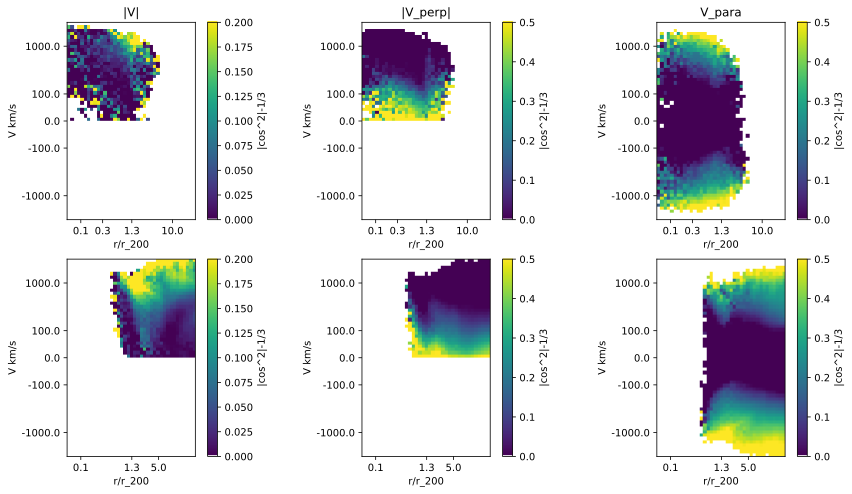

In [11]:
r_bins=10**np.linspace(-1.3,1.5,40)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,30)[::-1],[0],10**np.linspace(1.5,3.5,30)])


label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_cos(ax[0,0], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_len_1h[label1], cos=cos_v_r_1h[label1], vmax=.2, vmin=0, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,0], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_len_2h[label2], cos=cos_v_r_2h[label2], vmax=.2, vmin=0, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,1], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_perp_1h[label1], cos=cos_v_r_1h[label1], vmax=.5, vmin=0, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,1], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_perp_2h[label2], cos=cos_v_r_2h[label2], vmax=.5, vmin=0, r_ticks=[0.1,1.3, 5])

plot_v_r_2d_hist_cos(ax[0,2], r_bins, v_bins, r=r_len_1h[label1]/r_200_1h[label1], v=v_para_1h[label1], cos=cos_v_r_1h[label1], vmax=.5, vmin=0, r_ticks=[0.1,0.3,1.3,10])
plot_v_r_2d_hist_cos(ax[1,2], r_bins, v_bins, r=r_len_2h[label2]/r_200_2h[label2], v=v_para_2h[label2], cos=cos_v_r_2h[label2], vmax=.5, vmin=0, r_ticks=[0.1,1.3, 5])

ax[0,0].set_title("|V|")
ax[0,1].set_title("|V_perp|")
ax[0,2].set_title("V_para")


### 3 panels r-V, cos<v.A>, r(cos(vA), r(cos(rA)))

12 (12, 11) 0 -0.13091876305422032 0.3237015362950877
32 (32, 31) 1 -0.45644448002042776 0.14647985064248858
49 (49, 48) 2 -0.24761810870976222 0.13662541516735027
119 (119, 118) 3 -0.3532013446751198 0.08537184554901145
333 (333, 332) 4 -0.4739848640194266 0.04668235973683874
793 (793, 792) 5 -0.5308256241845759 0.027640701270799962
2000 (2000, 1999) 6 -0.5201578993638918 0.017843790267077858
4607 (4607, 4606) 7 -0.5026201482887119 0.012035470596683362
9886 (9886, 9885) 8 -0.4776555959297734 0.008449885262436481
16947 (16947, 16946) 9 -0.48113438992584295 0.006464483085073918
14477 (14477, 14476) 10 -0.445839105217718 0.007225492430817329
5378 (5378, 5377) 11 -0.46499407306665475 0.011729203220575826
1891 (1891, 1890) 12 -0.5147269772187512 0.017477221213099227
464 (464, 463) 13 -0.6837797538928153 0.026838381243916725
26 (26, 25) 14 -0.8817195868709056 0.03809657239374395


Text(0, 0.5, '|cos<rV>^2|-1/3')

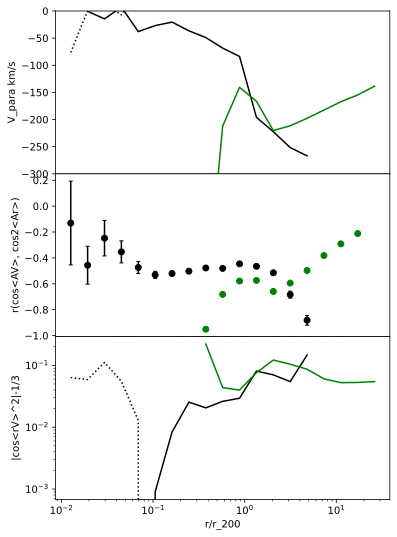

In [9]:
from astropy.stats import jackknife_stats
from astropy.stats import jackknife_resampling

r_bins=10**np.linspace(-2,1.5,20)
fig,ax=plt.subplots(3,1,figsize=(1*6,3*3), sharex=True, gridspec_kw={"hspace":0,"wspace":0,})

label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10))
label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
# vel profile
plot_histogram(ax=ax[0], x=r_len_1h[label1]/r_200_1h[label1], y=v_para_1h[label1], bins=r_bins, c="k", label=r"In group", alpha=1)
plot_histogram(ax=ax[2], x=r_len_1h[label1]/r_200_1h[label1], y=cos_v_r_1h[label1]**2-1/3., bins=r_bins, c="k", label=r"In group", alpha=1)

plot_histogram(ax=ax[0], x=r_len_2h[label2]/r_200_2h[label2], y=v_para_2h[label2], bins=r_bins, c="g", label=r"In group", alpha=1)
plot_histogram(ax=ax[2], x=r_len_2h[label2]/r_200_2h[label2], y=cos_v_r_2h[label2]**2-1/3., bins=r_bins, c="g", label=r"In group", alpha=1)



# correlation between coses 1h
for i in range(len(r_bins)-1):   
    label1=np.where((M_200_1h>10**13/10**10)&(M_200_1h<10**15/10**10)&(r_len_1h/r_200_1h>r_bins[i])&(r_len_1h/r_200_1h<r_bins[i+1]))[0]
    #label2=np.where((M_200_2h>10**12/10**10)&(M_200_2h<10**15/10**10))
    
    if len(label1)==0:
        continue
    
    c_ij_1h=cos_v_A_1h[label1]*cos_A_r_1h[label1]
    c_ii_1h=cos_v_A_1h[label1]*cos_v_A_1h[label1]
    c_jj_1h=cos_A_r_1h[label1]*cos_A_r_1h[label1]
    
    resamples = jackknife_resampling(np.arange(len(label1))).astype(np.int)
    r_cos=np.zeros((resamples.shape[0]))
    
    for j in range(resamples.shape[0]):
        r_cos[j]=np.mean(c_ij_1h[resamples[j,:]])/np.sqrt(np.mean(c_ii_1h[resamples[j,:]])*np.mean(c_jj_1h[resamples[j,:]]))
    r_cos_mean=np.mean(r_cos)
    r_cos_err=np.sqrt((resamples.shape[0]-1)/(resamples.shape[0])*np.sum((r_cos-r_cos_mean)**2))
    print(len(label1), resamples.shape,i, r_cos_mean, r_cos_err)
    
    ax[1].errorbar((r_bins[i]+r_bins[i+1])/2,r_cos_mean, r_cos_err,c="k", fmt="o",capsize=2)
    
for i in range(len(r_bins)-1):   
    #label1=np.where((M_200_1h>10**12/10**10)&(M_200_1h<10**15/10**10)&(r_len_1h/r_200_1h>r_bins[i])&(r_len_1h/r_200_1h<r_bins[i+1]))[0]
    label2=np.where((M_200_2h>10**13/10**10)&(M_200_2h<10**15/10**10)&(r_len_2h/r_200_2h>r_bins[i])&(r_len_2h/r_200_2h<r_bins[i+1]))[0]
    
    if len(label2)==0:
        continue
    
    c_ij_2h=cos_v_A_2h[label2]*cos_A_r_2h[label2]
    c_ii_2h=cos_v_A_2h[label2]*cos_v_A_2h[label2]
    c_jj_2h=cos_A_r_2h[label2]*cos_A_r_2h[label2]
    
    ax[1].plot((r_bins[i]+r_bins[i+1])/2,np.mean(c_ij_2h)/np.sqrt(np.mean(c_ii_2h)*np.mean(c_jj_2h)),"og")
    
    
for i in [0,1,2]:
    ax[i].set_xscale("log")
    #ax[i].set_yscale("log")
    #ax[i].set_xlim(r_bins[0], r_bins[-1])
    #ax[i].set_ylim(0.005,0.5)
    #ax[i].set_xlabel("r Mpc/h")

ax[2].set_yscale("log")
ax[2].set_xlabel("r/r_200")

ax[0].set_ylim(-300, 0)

ax[0].set_ylabel("V_para km/s")
ax[1].set_ylabel("r(cos<AV>, cos2<Ar>)")
ax[2].set_ylabel("|cos<rV>^2|-1/3")

#ax[0,2].legend(loc=3)

In [73]:
v_bins

array([-0.15848932, -0.13847753, -0.12099255, -0.10571532, -0.09236709,
       -0.08070428, -0.07051408, -0.06161056, -0.05383125, -0.0470342 ,
       -0.04109539, -0.03590645, -0.03137269, -0.02741139, -0.02395027,
       -0.02092617, -0.01828391, -0.01597527, -0.01395814, -0.0121957 ,
       -0.0106558 , -0.00931034, -0.00813476, -0.00710762, -0.00621017,
       -0.00542604, -0.00474091, -0.0041423 , -0.00361927, -0.00316228,
        0.        ,  0.00316228,  0.00361927,  0.0041423 ,  0.00474091,
        0.00542604,  0.00621017,  0.00710762,  0.00813476,  0.00931034,
        0.0106558 ,  0.0121957 ,  0.01395814,  0.01597527,  0.01828391,
        0.02092617,  0.02395027,  0.02741139,  0.03137269,  0.03590645,
        0.04109539,  0.0470342 ,  0.05383125,  0.06161056,  0.07051408,
        0.08070428,  0.09236709,  0.10571532,  0.12099255,  0.13847753,
        0.15848932])

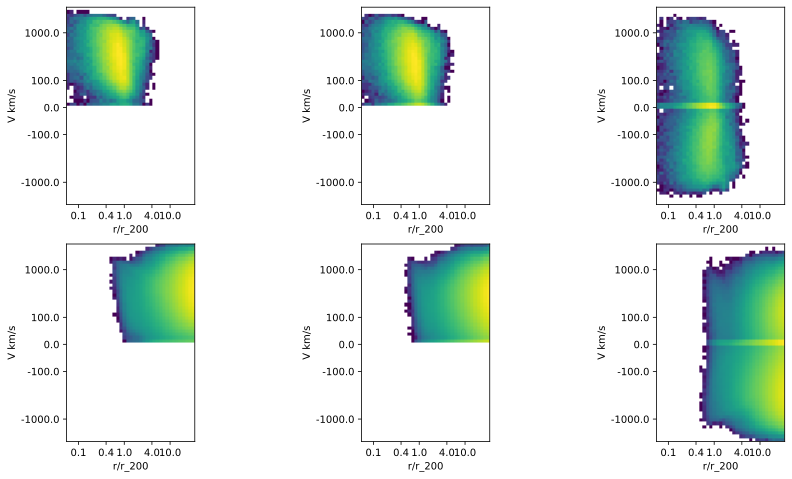

In [24]:
fig,ax=plt.subplots(2,3, figsize=(5*3, 4*2))
plot_v_r_2d_hist_N(ax[0,0], r_bins, v_bins, r=r_len_1h/r_200_1h, v=v_len_1h)
plot_v_r_2d_hist_N(ax[1,0], r_bins, v_bins, r=r_len_2h/r_200_2h, v=v_len_2h)

plot_v_r_2d_hist_N(ax[0,1], r_bins, v_bins, r=r_len_1h/r_200_1h, v=v_perp_1h)
plot_v_r_2d_hist_N(ax[1,1], r_bins, v_bins, r=r_len_2h/r_200_2h, v=v_perp_2h)

plot_v_r_2d_hist_N(ax[0,2], r_bins, v_bins, r=r_len_1h/r_200_1h, v=v_para_1h)
plot_v_r_2d_hist_N(ax[1,2], r_bins, v_bins, r=r_len_2h/r_200_2h, v=v_para_2h)

[Text(5.237803249699268, 0, '0.10'),
 Text(10.501592197440033, 0, '0.20'),
 Text(17.465568306743542, 0, '0.50'),
 Text(22.737532866594922, 0, '1.00'),
 Text(28.01688510962008, 0, '2.00'),
 Text(34.98078604602991, 0, '5.00'),
 Text(40.23780324969927, 0, '10.00')]

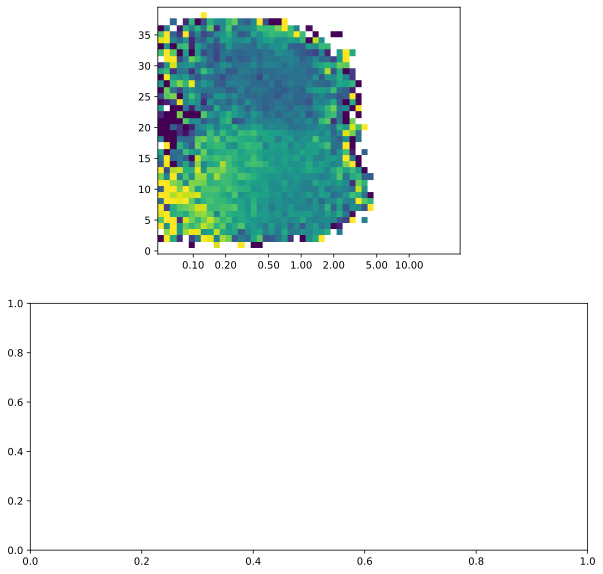

In [50]:

r_bins=10**np.linspace(-1.3,1.5,50)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,20)[::-1],[0],10**np.linspace(1.5,3.5,20)])

q_mean_1h, r_edge, v_edge= plot_v_r_2d_hist(r_bins, v_bins, r=r_len_1h/r_200_1h, v=v_para_1h, q=q_1h)
#q_mean_2h, r_edge, v_edge= plot_v_r_2d_hist(r_bins, v_bins, r=r_len_2h/r_200_2h, v=v_para_2h, q=q_2h)

fig,ax=plt.subplots(2, 1,figsize=(5*2,10))
ax[0].imshow(q_mean_1h, origin="lower",vmax=0.8, vmin=0.6)
#ax[1].imshow(q_mean_2h, origin="lower",vmax=0.75, vmin=0.65)

label_loc_r, label_str_r=turn_label_tick(label_ticks=[0.1,0.2,0.5,1,2,5,10], imshow_ticks=r_bins)
ax[0].set_xticks(label_loc_r)
ax[0].set_xticklabels(label_str_r)

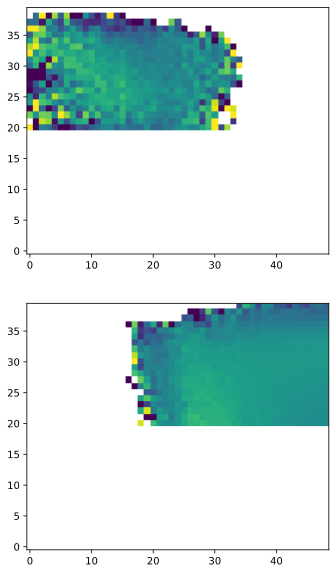

In [38]:
r_bins=10**np.linspace(-1.3,1.5,50)
v_bins=np.hstack([[0],10**np.linspace(1.5,3.5,20)])

q_mean_1h, r_edge, v_edge= plot_v_r_2d_hist(r_bins, v_bins, r=r_len_1h/r_200_1h, v=v_perp_1h, q=q_1h)
q_mean_2h, r_edge, v_edge= plot_v_r_2d_hist(r_bins, v_bins, r=r_len_2h/r_200_2h, v=v_perp_2h, q=q_2h)

fig,ax=plt.subplots(2, 1,figsize=(5*2,10))
ax[0].imshow(q_mean_1h, origin="lower",vmax=0.8, vmin=0.6)
ax[1].imshow(q_mean_2h, origin="lower",vmax=0.8, vmin=0.6)

In [15]:
r_bins=10**np.linspace(-1.3,1.5,30)
v_bins=np.hstack([-10**np.linspace(1.5,3.5,10)[::-1],[0],10**np.linspace(1.5,3.5,10)])

N_1h, r_edge, v_edge=np.histogram2d(v_para_1h, r_len_1h/r_200_1h, bins=[ v_bins, r_bins], )
q_mean_1h, r_edge, v_edge=np.histogram2d(v_para_1h, r_len_1h/r_200_1h, bins=[ v_bins, r_bins], weights=q_1h)
q_mean_1h=q_mean_1h/N_1h

N_2h, r_edge, v_edge=np.histogram2d(v_para_2h, r_len_2h/r_200_2h, bins=[ v_bins, r_bins], )
q_mean_2h, r_edge, v_edge=np.histogram2d(v_para_2h, r_len_2h/r_200_2h, bins=[ v_bins, r_bins], weights=q_2h)
q_mean_2h=q_mean_2h/N_2h

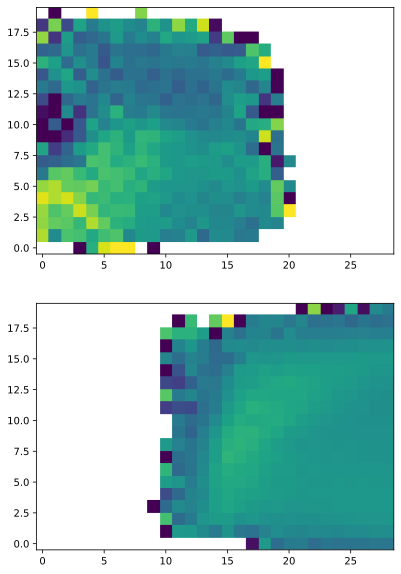

In [21]:
fig,ax=plt.subplots(2, 1,figsize=(5*2,10))
ax[0].imshow(q_mean_1h, origin="lower",vmax=0.8, vmin=0.6)
ax[1].imshow(q_mean_2h, origin="lower",vmax=0.8, vmin=0.6)
#plt.colorbar(ax=ax)

(0.6, 0.8)

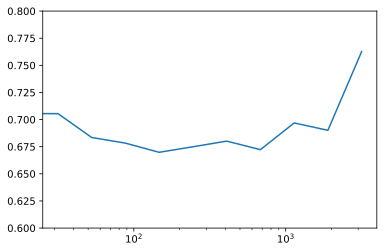

In [34]:
plt.plot(r_edge[1:], q_mean_1h[:,8])
plt.xscale("log")
plt.ylim(0.6,0.8)

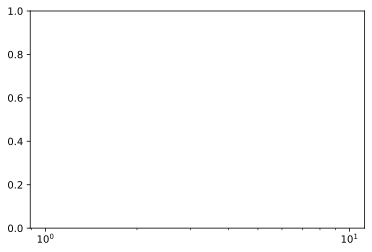

In [59]:
# plt.plot(-r_edge[1:], q_mean)
plt.xscale("log")

## tracer: subgroup & subgroup

### 以M_*为筛选条件

910


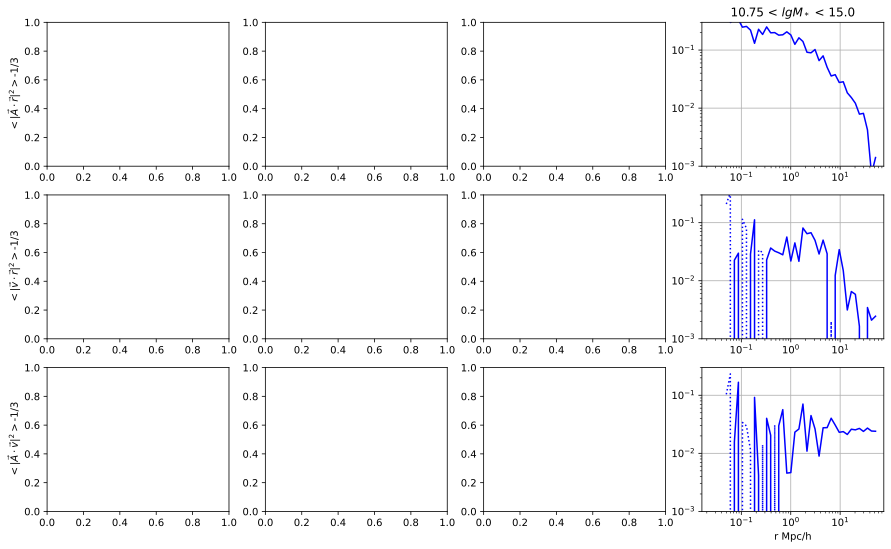

In [17]:
def get_sub_sub(subgroup_star_mass_min,subgroup_star_mass_max, r_max=10**4):
    #r_bins=10**np.linspace(2,4.3)
    label=np.where((SubhaloMass_Star>=subgroup_star_mass_min/10**10)&(SubhaloMass_Star<=subgroup_star_mass_max/10**10)&(subgroup_value_dm[:,0]!=0))[0]
    print(len(label))
    subgroup_tree=KDTree(SubhaloPos[label,:], boxsize=boxlen_100)
    #N_sub_rbins=subgroup_tree.count_neighbors(subgroup_tree,r=r_bins, cumulative=False)
    pair_index=subgroup_tree.query_pairs(r=r_max, output_type="ndarray")

    r=get_pos_diff(pos_a=SubhaloPos[label[pair_index[:,1]],:],pos_b=SubhaloPos[label[pair_index[:,0]],:],boxlen=boxlen_100) #b-a
    r_len=np.linalg.norm(r, axis=1)
    
    
    v=SubhaloVel[label[pair_index[:,0]],:]-GroupVel[label[pair_index[:,1]],:]
    v_len=np.linalg.norm(v, axis=1)
        

    A1=subgroup_vector_dm[label[pair_index[:,0]],:,0]#;a=w[subgroup_id[j],0];b=w[subgroup_id[j],1]
    A2=subgroup_vector_dm[label[pair_index[:,1]],:,0]

    cos_A_r1=np.sum(A1*r, axis=1)/r_len
    cos_A_r2=np.sum(A2*r, axis=1)/r_len
    
    cos_v_r=np.sum(v*r,axis=1)/v_len/r_len
    
    
    cos_v_A1=np.sum(v*A1,axis=1)/v_len/np.linalg.norm(A1, axis=1)
    cos_v_A2=np.sum(v*A2,axis=1)/v_len/np.linalg.norm(A2, axis=1)


    return np.hstack([r_len, r_len])/1000, np.hstack([cos_A_r1,cos_A_r2]),  np.hstack([cos_v_r,cos_v_r]),  np.hstack([cos_v_A1,cos_v_A2])

fig,ax=plt.subplots(3, 4, figsize=(15,3*3))
r_bins=10**np.linspace(-2,2,50)

lgM_lim=np.array([[9,15],[9,10],[10,10.75],[10.75,15]])

for i in [3]:
    r_len, cos_A_r, cos_v_r, cos_v_A=get_sub_sub(10**(lgM_lim[i,0]), 10**(lgM_lim[i,1]), r_max=50*10**3)
    plot_histogram(ax=ax[0,i], x=r_len, y=cos_A_r**2-1/3., bins=r_bins, c="b", label=r"")
    plot_histogram(ax=ax[1,i], x=r_len, y=cos_v_r**2-1/3., bins=r_bins, c="b", label=r"")
    plot_histogram(ax=ax[2,i], x=r_len, y=cos_v_A**2-1/3., bins=r_bins, c="b", label=r"")

    for j in [0,1,2]:
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")

        ax[2,i].set_xlabel("r Mpc/h")
        
        #ax[i].legend(loc=3)
        ax[j,i].grid()
        #ax[j,i].set_xlim(10**-1.2,10**1.5)
        ax[j,i].set_ylim(10**-3,0.3)
        ax[0,i].set_title(str(lgM_lim[i,0])+" < $lgM_*$ < "+str(lgM_lim[i,1]))
        
    ax[0,0].set_ylabel(r"$<|\vec A \cdot \vec r|^2>$-1/3")
    ax[1,0].set_ylabel(r"$<|\vec v \cdot \vec r|^2>$-1/3")
    ax[2,0].set_ylabel(r"$<|\vec A \cdot \vec v|^2>$-1/3")



In [13]:
print(np.min(r_len), np.max(r_len))

0.022683186 19.999544


In [15]:
cos_v_A

array([-0.98398492, -0.72147765,  0.76563511, ...,  0.3155724 ,
        0.97008344,  0.94155264])